In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm, metrics
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models


import skimage.io as io
from skimage.io import imread
from skimage.transform import resize
from PIL import Image

import os
from tqdm import tqdm
from glob import glob

In [4]:
#导入图像并转化为numpy数组
train_path = 'image/'
tumor_label=pd.read_csv('label.csv')
img_size = 200
label = []
nub_train = len(glob(train_path + '/*.jpg'))
image_data = np.zeros((nub_train,img_size,img_size,3),dtype=np.uint8)

i = 0   
for img_path in tqdm(glob(train_path + '/*.jpg')):
    img = Image.open(img_path)
    img = img.resize((img_size,img_size)) #图片resize
    arr = np.asarray(img) #图片转array
    image_data[i, :, :, :] = arr #赋值
    i += 1

for i in range(3000):
    data = tumor_label['label'][i]
    if data == 'no_tumor':
        label.append(0)
    else :
        label.append(1)    
    
    
image_data = np.array(image_data,dtype='float32')/255.0
label = np.array(label)

100%|██████████| 3000/3000 [00:11<00:00, 254.85it/s]


In [5]:
new_image = np.delete(image_data, [1,2], axis=3 )

In [6]:
new_image.shape

(3000, 200, 200, 1)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(new_image, label, test_size=0.2, random_state=3)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=3)

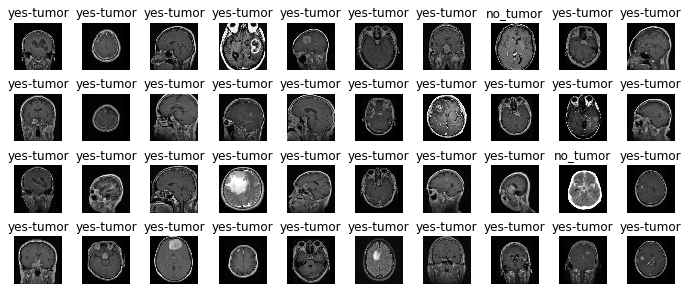

In [7]:
class_names = ["no_tumor", "yes-tumor"]
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.savefig('tumor')
plt.show()

In [21]:
model = models.Sequential([
  layers.Conv2D(16, kernel_size=3, padding='same', activation='relu', input_shape=(200, 200, 1)),
  layers.MaxPooling2D(pool_size=2),
  layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2),
  layers.Conv2D(64, kernel_size=3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=2),
  layers.Flatten(),
  layers.Dense(units=128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(units=64, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(1, activation="sigmoid")
])


In [22]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 200, 200, 16)      160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 40000)            

In [23]:
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
57/57 [==============================] - 15s 268ms/step - loss: 0.5043 - accuracy: 0.8394 - val_loss: 0.3881 - val_accuracy: 0.8600
Epoch 2/10
57/57 [==============================] - 15s 261ms/step - loss: 0.3787 - accuracy: 0.8422 - val_loss: 0.2756 - val_accuracy: 0.8600
Epoch 3/10
57/57 [==============================] - 15s 261ms/step - loss: 0.2895 - accuracy: 0.8606 - val_loss: 0.2363 - val_accuracy: 0.8917
Epoch 4/10
57/57 [==============================] - 15s 264ms/step - loss: 0.2628 - accuracy: 0.8706 - val_loss: 0.2114 - val_accuracy: 0.9167
Epoch 5/10
57/57 [==============================] - 15s 268ms/step - loss: 0.2142 - accuracy: 0.9039 - val_loss: 0.2182 - val_accuracy: 0.9117
Epoch 6/10
57/57 [==============================] - 15s 266ms/step - loss: 0.1973 - accuracy: 0.9139 - val_loss: 0.1808 - val_accuracy: 0.9267
Epoch 7/10
57/57 [==============================] - 15s 258ms/step - loss: 0.1482 - accuracy: 0.9356 - val_loss: 0.1735 - val_accuracy: 0.9233

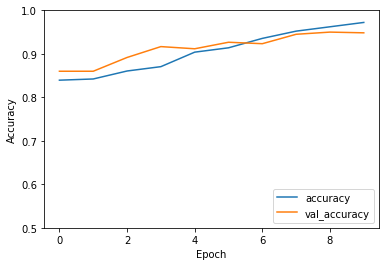

19/19 - 1s - loss: 0.1222 - accuracy: 0.9467


In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

In [25]:
print(test_acc)

0.9466666579246521
